In [1]:
import  matplotlib.pyplot as plt
import pandas as pd
import datetime


import lightgbm
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_curve,auc,roc_auc_score,mean_squared_error
from sklearn.model_selection import train_test_split
import toad

pd.set_option("display.max_columns",50)

In [2]:
train_bank = pd.read_csv('data/train_public.csv')

print(train_bank.shape)
train_bank.head()

(10000, 39)


,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1040418,240418,31818.18182,3,11.466,1174.91,C,政府机构,金融业,3 years,0,1,2016/10/1,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,1-Dec,5,1,1.0,0.0,4.0,5.0,4.0,3,9927,0.0,0
1,1025197,225197,28000.00000,5,16.841,670.69,C,政府机构,金融业,10+ years,0,2,2013/6/1,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,Apr-90,40642,1,7.0,0.0,4.0,45.0,22.0,0,0,0.0,0
2,1009360,209360,17272.72727,3,8.900,603.32,A,政府机构,公共服务、社会组织,10+ years,1,0,2014/1/1,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,Oct-91,154,1,6.0,0.0,6.0,28.0,19.0,0,0,0.0,0
3,1039708,239708,20000.00000,3,4.788,602.30,A,世界五百强,文化和体育业,6 years,0,1,2015/7/1,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,1-Jun,0,1,5.0,0.0,10.0,15.0,9.0,0,0,0.0,0
4,1027483,227483,15272.72727,3,12.790,470.31,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016/7/1,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,2-May,0,1,10.0,0.0,6.0,15.0,4.0,0,0,0.0,0


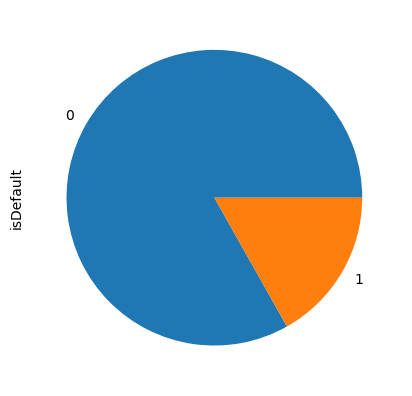

In [3]:
## 好坏样本的占比
train_bank.isDefault.value_counts().plot(kind='pie')

## 数据预处理

In [4]:
# 日期类型：issueDate 转换为pandas中的日期类型，加工出数值特征
train_bank['issue_date'] = pd.to_datetime(train_bank['issue_date'])
# 提取多尺度特征
train_bank['issue_date_y'] = train_bank['issue_date'].dt.year
train_bank['issue_date_m'] = train_bank['issue_date'].dt.month
# 提取时间diff # 转换为天为单位
base_time = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')   # 随机设置初始的基准时间
train_bank['issue_date_diff'] = train_bank['issue_date'].apply(lambda x: x-base_time).dt.days
# 可以发现earlies_credit_mon应该是年份-月的格式，这里简单提取年份
train_bank['earlies_credit_mon'] = train_bank['earlies_credit_mon'].map(lambda x:int(sorted(x.split('-'))[0]))
train_bank.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_date_y,issue_date_m,issue_date_diff
0,1040418,240418,31818.18182,3,11.466,1174.91,C,政府机构,金融业,3 years,0,1,2016-10-01,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,1,5,1,1.0,0.0,4.0,5.0,4.0,3,9927,0.0,0,2016,10,6118
1,1025197,225197,28000.00000,5,16.841,670.69,C,政府机构,金融业,10+ years,0,2,2013-06-01,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,90,40642,1,7.0,0.0,4.0,45.0,22.0,0,0,0.0,0,2013,6,4900
2,1009360,209360,17272.72727,3,8.900,603.32,A,政府机构,公共服务、社会组织,10+ years,1,0,2014-01-01,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,91,154,1,6.0,0.0,6.0,28.0,19.0,0,0,0.0,0,2014,1,5114
3,1039708,239708,20000.00000,3,4.788,602.30,A,世界五百强,文化和体育业,6 years,0,1,2015-07-01,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,1,0,1,5.0,0.0,10.0,15.0,9.0,0,0,0.0,0,2015,7,5660
4,1027483,227483,15272.72727,3,12.790,470.31,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016-07-01,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,2,0,1,10.0,0.0,6.0,15.0,4.0,0,0,0.0,0,2016,7,6026


In [5]:
train_bank['employer_type'].value_counts()

普通企业       4610
政府机构       2474
幼教与中小学校    1053
上市企业        958
世界五百强       542
高等教育机构      363
Name: employer_type, dtype: int64

In [6]:
train_bank['industry'].value_counts()

金融业                1629
电力、热力生产供应业         1248
公共服务、社会组织          1065
住宿和餐饮业              907
信息传输、软件和信息技术服务业     808
文化和体育业              793
建筑业                 704
房地产业                554
采矿业                 506
交通运输、仓储和邮政业         492
农、林、牧、渔业            466
制造业                 302
批发和零售业              279
国际组织                247
Name: industry, dtype: int64

In [7]:
# 工作年限处理
train_bank['work_year'].fillna('10+ years', inplace=True)

work_year_map = {'10+ years': 10, '2 years': 2, '< 1 year': 0, '3 years': 3, '1 year': 1,
     '5 years': 5, '4 years': 4, '6 years': 6, '8 years': 8, '7 years': 7, '9 years': 9}
train_bank['work_year']  = train_bank['work_year'].map(work_year_map)

train_bank['class'] = train_bank['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

# 缺失值处理
train_bank = train_bank.fillna('9999')

In [8]:
# 区分 数值 或类别特征

drop_list = ['isDefault','earlies_credit_mon','loan_id','user_id','issue_date']
num_feas = []
cate_feas = []

for col in train_bank.columns:
    if col not in drop_list:
        try:
            train_bank[col] = pd.to_numeric(train_bank[col]) # 转为数值
            num_feas.append(col)
        except:
            train_bank[col] = train_bank[col].astype('category')
            cate_feas.append(col)
            
print(cate_feas)
print(num_feas)

['employer_type', 'industry']
['total_loan', 'year_of_loan', 'interest', 'monthly_payment', 'class', 'work_year', 'house_exist', 'censor_status', 'use', 'post_code', 'region', 'debt_loan_ratio', 'del_in_18month', 'scoring_low', 'scoring_high', 'known_outstanding_loan', 'known_dero', 'pub_dero_bankrup', 'recircle_b', 'recircle_u', 'initial_list_status', 'app_type', 'title', 'policy_code', 'f0', 'f1', 'f2', 'f3', 'f4', 'early_return', 'early_return_amount', 'early_return_amount_3mon', 'issue_date_y', 'issue_date_m', 'issue_date_diff']


## 选择模型1--LightGBM

lgb树模型是集成学习的强模型，自带缺失、类别变量的处理，特征上面不用做很多处理，建模非常方便。

In [9]:
def model_metrics(model, x, y):
    """ 评估 """
    yhat = model.predict(x)
    yprob = model.predict_proba(x)[:,1]
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    metrics = {'AUC':auc(fpr, tpr),'KS':max(tpr-fpr),
               'f1':f1_score(y,yhat),'P':precision_score(y,yhat),'R':recall_score(y,yhat)}
    
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)

    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
    plt.title('ROC Curve')
    plt.legend(loc="lower right")


    return metrics

train  {'AUC': 0.8766158029476853, 'KS': 0.6579021970233876, 'f1': 0.5673795413553209, 'P': 0.40914158305462656, 'R': 0.9252100840336135}
test  {'AUC': 0.865667813691643, 'KS': 0.6284431987999525, 'f1': 0.5419664268585132, 'P': 0.38468085106382977, 'R': 0.9168356997971603}


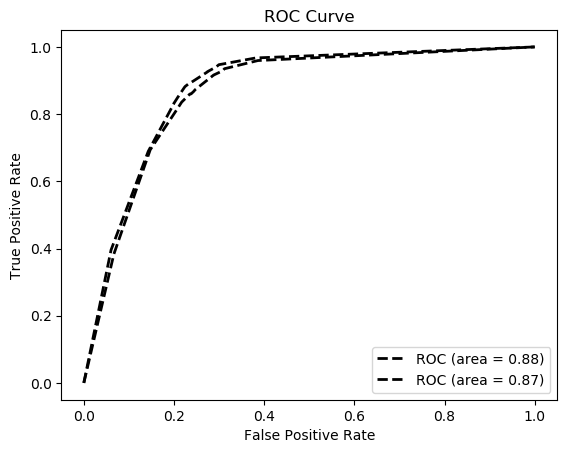

In [10]:
# 划分数据集：训练集和测试集
train_x, test_x, train_y, test_y = train_test_split(train_bank[num_feas + cate_feas],\
                                                     train_bank.isDefault,test_size=0.3, random_state=0)

# 训练模型
lgb=lightgbm.LGBMClassifier(n_estimators=5, num_leaves=5,class_weight= 'balanced',metric = 'AUC')
lgb.fit(train_x, train_y)
print('train ',model_metrics(lgb,train_x, train_y))
print('test ',model_metrics(lgb,test_x,test_y))

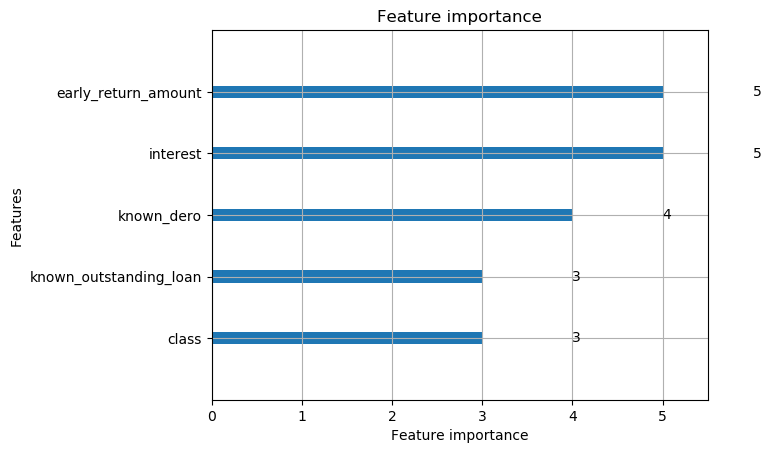

In [11]:
from lightgbm import plot_importance

plot_importance(lgb)

C:\Users\李岳\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\李岳\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\李岳\AppData\Roaming\Python\Python37\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\李岳\AppData\Roaming\Python\Python37\site-pack

train  {'AUC': 0.8732585805406501, 'KS': 0.6515439910904122, 'f1': 0.5673795413553209, 'P': 0.40914158305462656, 'R': 0.9252100840336135}
test  {'AUC': 0.8606817746010966, 'KS': 0.6284431987999525, 'f1': 0.5419664268585132, 'P': 0.38468085106382977, 'R': 0.9168356997971603}


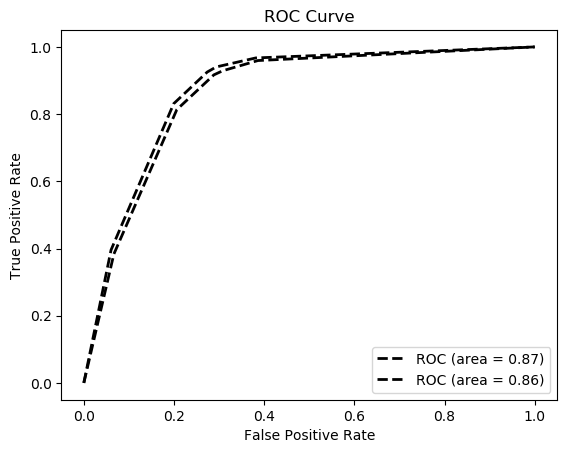

In [12]:
# 树模型决策的可视化

lgb=lightgbm.LGBMClassifier(n_estimators=1, num_leaves=6,class_weight= 'balanced')
lgb.fit(train_x, train_y,
        eval_set=[(test_x,test_y)],
        eval_metric='auc',
        early_stopping_rounds=50,
        verbose=-1)

print('train ',model_metrics(lgb,train_x, train_y))
print('test ',model_metrics(lgb,test_x,test_y))

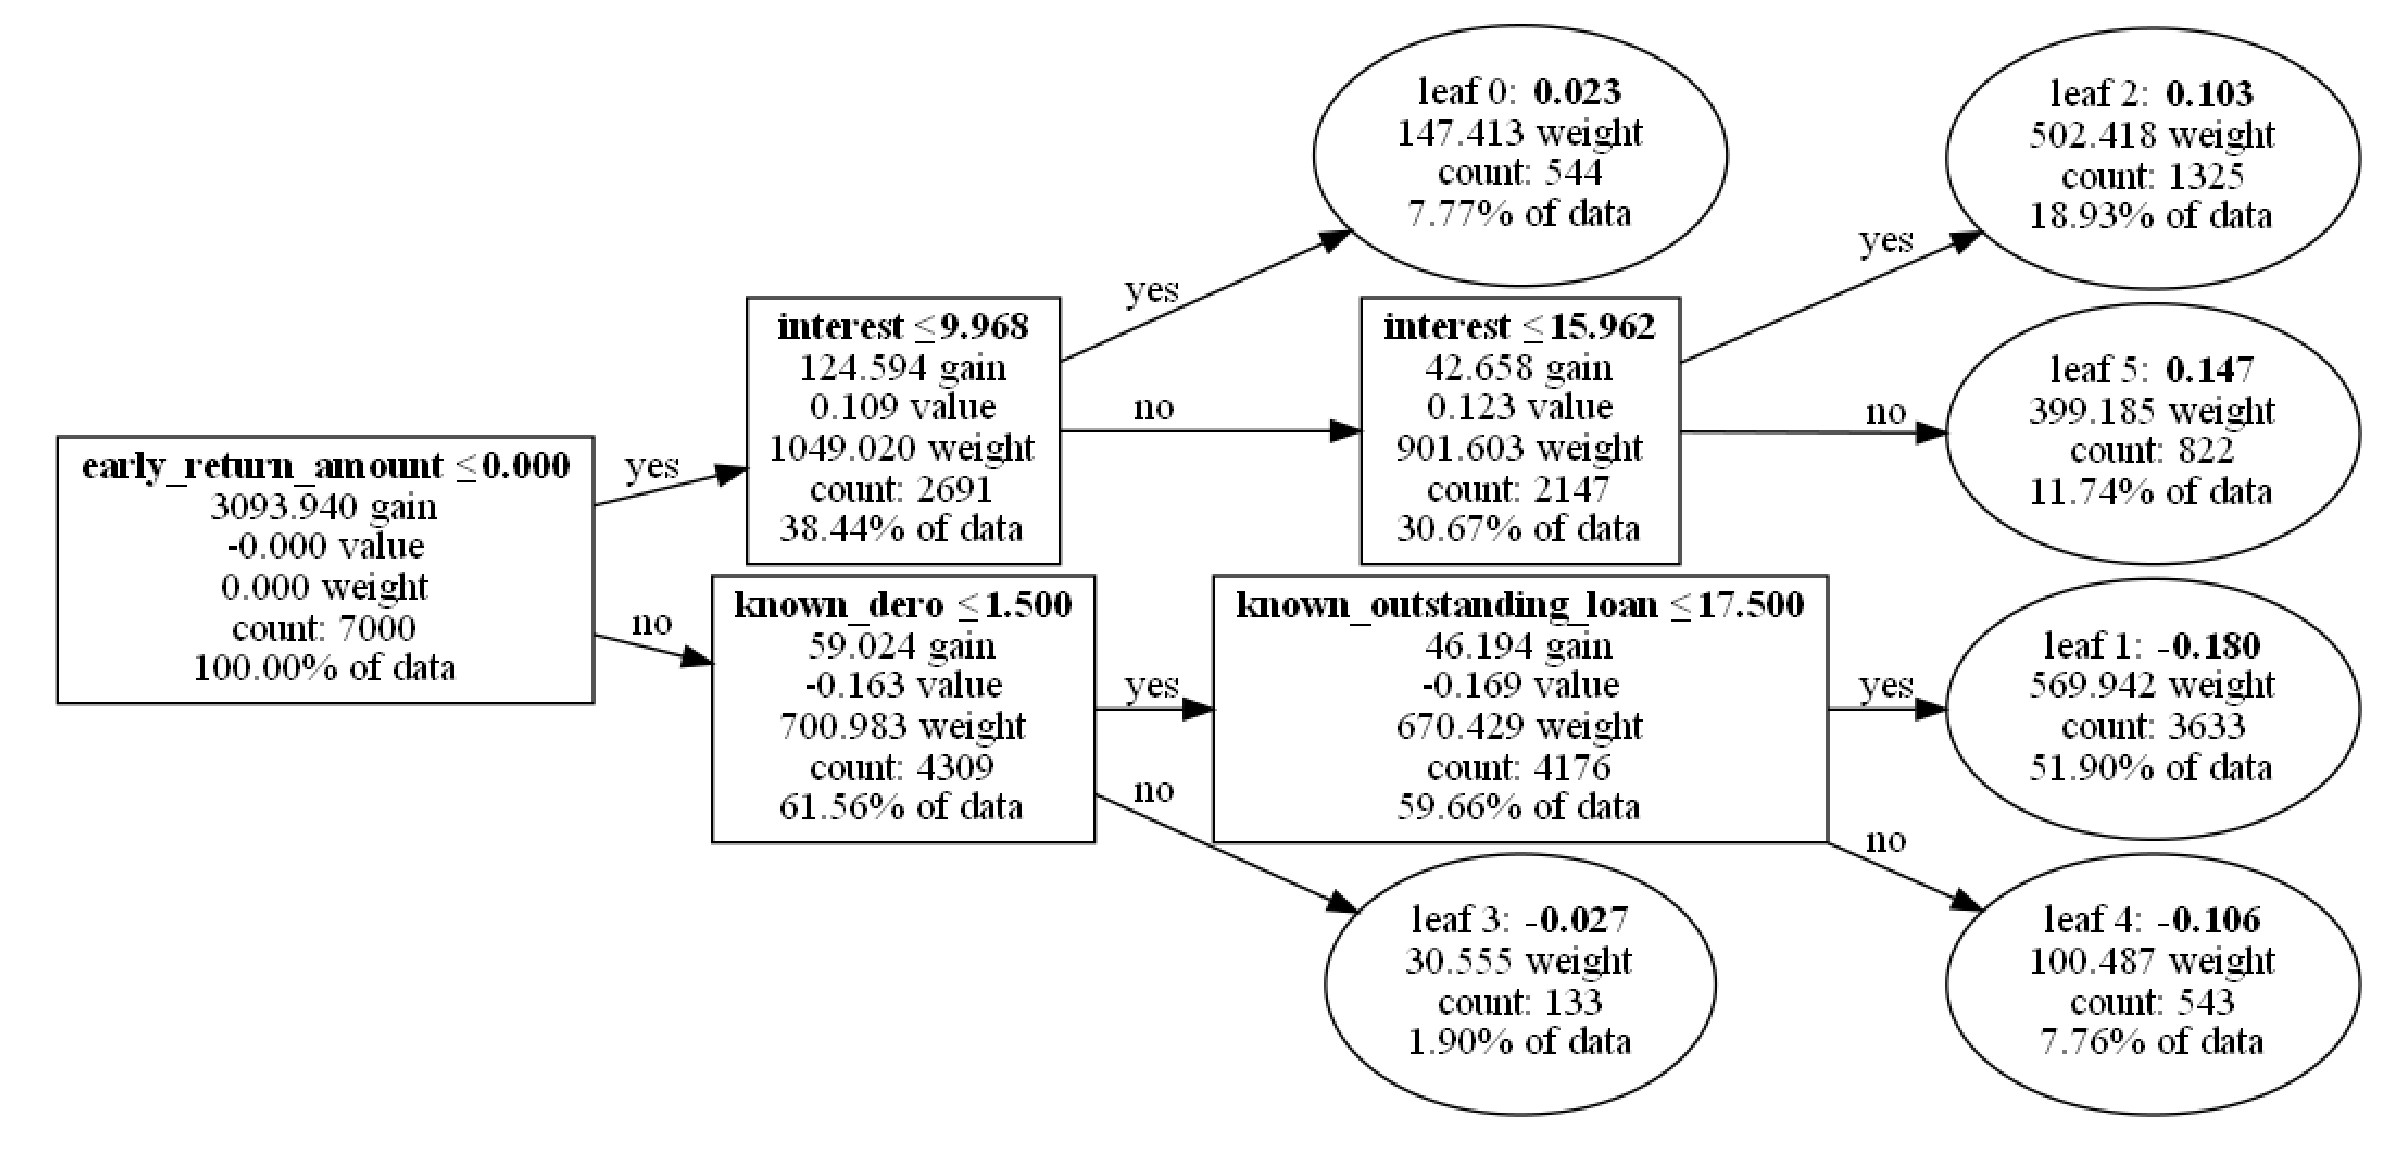

In [13]:
for k in range(1):
    ax = lightgbm.plot_tree(lgb, tree_index=k, figsize=(30,20),\
                             show_info=['split_gain','internal_value','internal_count',\
                                        'internal_weight','leaf_count','leaf_weight','data_percentage'])
plt.show()

In [14]:
lgb.booster_.save_model(filename="lgbmodel.txt")

In [15]:
lgb_mod = lightgbm.Booster(model_file="lgbmodel.txt")
yprob = lgb_mod.predict(test_x)
fpr,tpr,_ = roc_curve(test_y, yprob,pos_label=1)
print({'AUC':auc(fpr, tpr),'KS':max(tpr-fpr)})

{'AUC': 0.8606817746010966, 'KS': 0.6284431987999525}


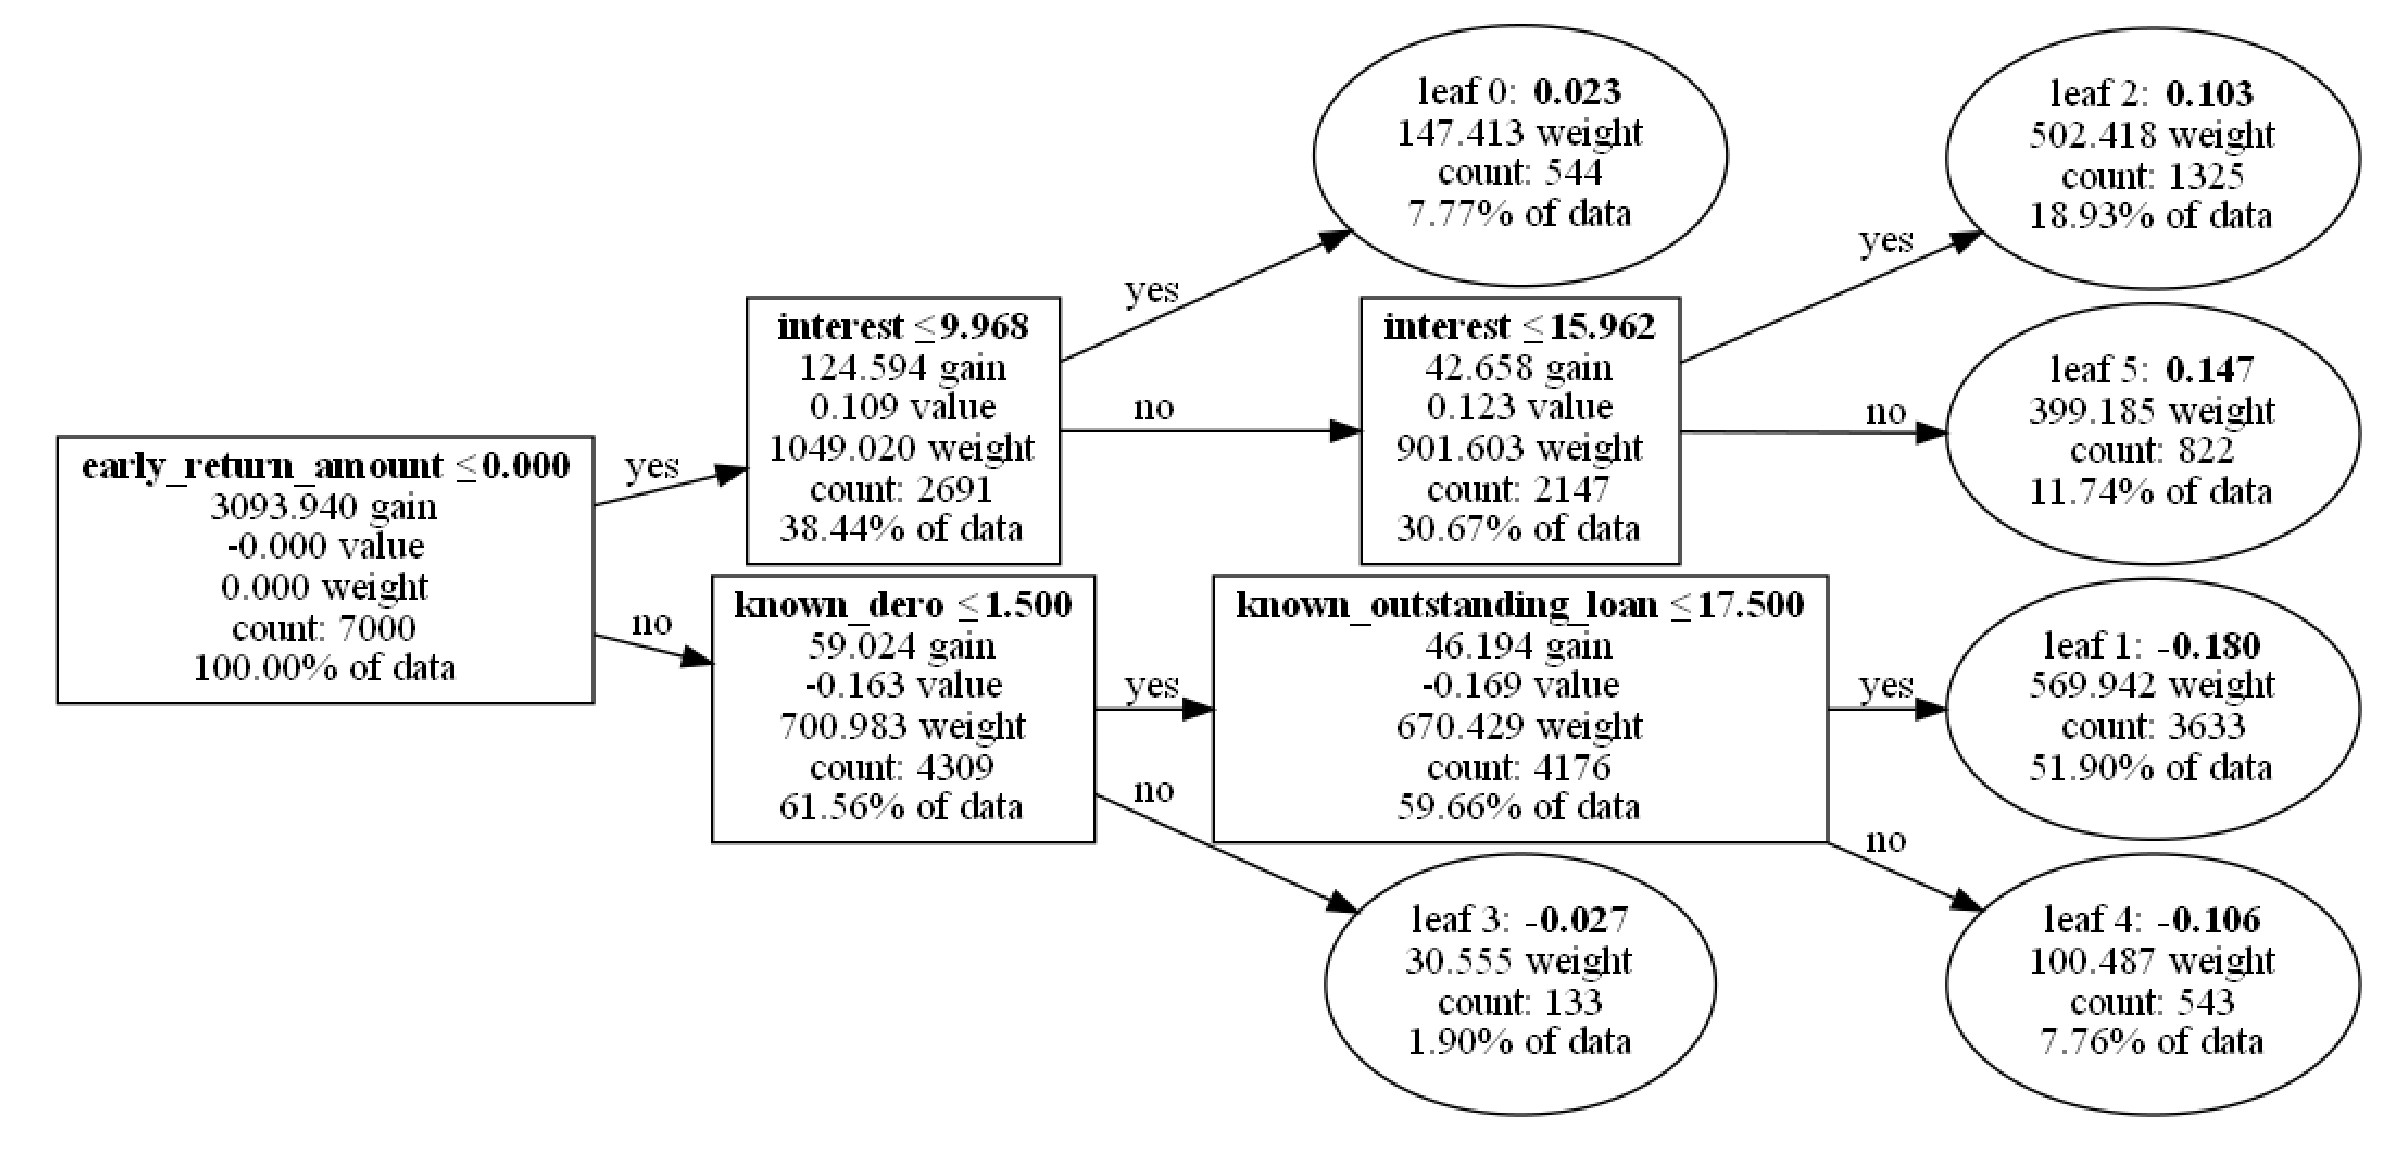

In [16]:
for k in range(1):
    ax = lightgbm.plot_tree(lgb_mod, tree_index=k, figsize=(30,20),\
                             show_info=['split_gain','internal_value','internal_count',\
                                        'internal_weight','leaf_count','leaf_weight','data_percentage'])
plt.show()

## 选择模型2--LR逻辑回归
1、使用Toad对特征离散化、Woe编码、调节单调性

In [17]:
# 数据EDA分析
toad.detector.detect(train_bank)

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
loan_id,int64,10000,0.00%,10000,1025209.5877,14386.820956,1000008.0,1000572.97,1005238.9,1025276.5,1037694.5,1045305.7,1049615.02,1049997.0
user_id,int64,10000,0.00%,10000,225209.5877,14386.820956,200008.0,200572.97,205238.9,225276.5,237694.5,245305.7,249615.02,249997.0
total_loan,float64,10000,0.00%,1632,14402.126591,8953.946807,818.181818,1599.909091,4545.454545,12272.72727,19636.36364,28000.0,39916.749999,47272.72727
year_of_loan,int64,10000,0.00%,2,3.4796,0.853965,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0
interest,float64,10000,0.00%,1028,13.222782,4.875755,4.779,5.32,7.348,12.639,15.9855,19.866,27.489,33.979
monthly_payment,float64,10000,0.00%,6377,436.960427,261.754396,30.44,53.3074,158.122,371.525,573.83,803.687,1231.4519,1503.89
class,int64,10000,0.00%,7,1.7475,1.285344,0.0,0.0,0.0,2.0,2.0,3.0,5.0,6.0
employer_type,category,10000,0.00%,6,普通企业:46.10%,政府机构:24.74%,幼教与中小学校:10.53%,上市企业:9.58%,世界五百强:5.42%,政府机构:24.74%,幼教与中小学校:10.53%,上市企业:9.58%,世界五百强:5.42%,高等教育机构:3.63%
industry,category,10000,0.00%,14,金融业:16.29%,电力、热力生产供应业:12.48%,公共服务、社会组织:10.65%,住宿和餐饮业:9.07%,信息传输、软件和信息技术服务业:8.08%,交通运输、仓储和邮政业:4.92%,农、林、牧、渔业:4.66%,制造业:3.02%,批发和零售业:2.79%,国际组织:2.47%
work_year,int64,10000,0.00%,11,6.3087,3.694262,0.0,0.0,1.0,7.0,10.0,10.0,10.0,10.0


In [18]:
# 特征选择,根据相关性 缺失率、IV 等指标
train_selected, dropped = toad.selection.select(train_bank,target = 'isDefault', \
                                                empty = 0.5, iv = 0.05, corr = 0.7, \
                                                return_drop=True, \
                                                exclude=['earlies_credit_mon','loan_id','user_id','issue_date'])
print(dropped)
print("特征选择后训练集的大小是 ", train_selected.shape)

{'empty': array([], dtype=float64), 'iv': array(['total_loan', 'monthly_payment', 'employer_type', 'industry',
       'work_year', 'house_exist', 'censor_status', 'use', 'post_code',
       'region', 'del_in_18month', 'scoring_high',
       'known_outstanding_loan', 'known_dero', 'pub_dero_bankrup',
       'recircle_b', 'recircle_u', 'initial_list_status', 'app_type',
       'policy_code', 'f1', 'f2', 'f3', 'f4', 'issue_date_y',
       'issue_date_m'], dtype=object), 'corr': array(['interest', 'early_return_amount_3mon'], dtype=object)}
特征选择后训练集的大小是  (10000, 14)


In [19]:
# 划分训练集 测试集
train_x, test_x, train_y, test_y = train_test_split(train_selected.drop(['loan_id','user_id','isDefault',\
                                                                'issue_date','earlies_credit_mon'],axis=1),
                                                    train_selected.isDefault,test_size=0.3, random_state=0)

In [20]:
# WOE编码
combiner = toad.transform.Combiner()

# 训练数据并指定分箱方法

combiner.fit(pd.concat([train_x,train_y], axis=1), y='isDefault',method= 'chi',min_samples = 0.05,exclude=[])

# 以字典形式保存分箱结果

bins = combiner.export()

bins 

{'year_of_loan': [5],
 'class': [1, 2, 3, 4],
 'debt_loan_ratio': [9.155454545, 23.44090909],
 'scoring_low': [560.4545455, 621.8181818, 660.0, 690.9090909, 730.0, 775.0],
 'title': [3],
 'f0': [7.0, 11.0],
 'early_return': [1],
 'early_return_amount': [51, 2127],
 'issue_date_diff': [5875, 6057]}

In [21]:
# 根据bad_rate图调整分箱的单调性。比如查看并调整debt_loan_ratio这个变量的分箱情况
adj_var = 'scoring_low'
# [560.4545455, 621.8181818, 660.0, 690.9090909, 730.0, 775.0]
adj_bin = {adj_var: [ 660.0, 700.9090909, 730.0, 775.0]}

c2 = toad.transform.Combiner()
c2.set_rules(adj_bin)

data_ = pd.concat([train_x,train_y], axis=1)
data_['type'] = 'train'
temp_data = c2.transform(data_[[adj_var,'isDefault','type']], labels=True)

In [22]:
from toad.plot import badrate_plot, proportion_plot, bin_plot

In [30]:
# badrate_plot(temp_data, target = 'isDefault', x = 'type', by = adj_var)
# proportion_plot(temp_data[adj_var])
bin_plot(temp_data, target = 'isDefault',x=adj_var)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: cannot convert float NaN to integer

<Figure size 1200x600 with 2 Axes>

In [24]:
# 更新调整后的分箱
combiner.set_rules(adj_bin)
combiner.export()

{'year_of_loan': [5],
 'class': [1, 2, 3, 4],
 'debt_loan_ratio': [9.155454545, 23.44090909],
 'scoring_low': [660.0, 700.9090909, 730.0, 775.0],
 'title': [3],
 'f0': [7.0, 11.0],
 'early_return': [1],
 'early_return_amount': [51, 2127],
 'issue_date_diff': [5875, 6057]}

In [25]:
#计算WOE，仅在训练集计算WOE，不然会标签泄露
transer = toad.transform.WOETransformer()
binned_data = combiner.transform(pd.concat([train_x,train_y], axis=1))

#对WOE的值进行转化，映射到原数据集上。对训练集用fit_transform,测试集用transform.
data_tr_woe = transer.fit_transform(binned_data, binned_data['isDefault'],  exclude=['isDefault'])
data_tr_woe.head()

,year_of_loan,class,debt_loan_ratio,scoring_low,title,f0,early_return,early_return_amount,issue_date_diff,isDefault
7681,-0.206792,-0.385727,-0.037954,0.063874,-0.111108,-0.107512,-2.224164,-2.514119,-0.090276,0
9031,-0.206792,0.195590,-0.037954,0.081927,0.097018,0.122153,0.863672,1.218112,-0.090276,0
3691,-0.206792,-0.385727,-0.432534,-0.576811,-0.111108,0.269066,-2.224164,-2.021976,-0.090276,0
202,-0.206792,0.362590,0.342059,0.081927,0.097018,0.269066,0.863672,1.218112,-0.090276,0
5625,-0.206792,0.195590,-0.432534,-0.084799,0.097018,-0.107512,0.863672,1.218112,0.007097,0


In [26]:
## test woe

# 先分箱
binned_data = combiner.transform(test_x)
#对WOE的值进行转化，映射到原数据集上。测试集用transform.
data_test_woe = transer.transform(binned_data)
data_test_woe.head()

,year_of_loan,class,debt_loan_ratio,scoring_low,title,f0,early_return,early_return_amount,issue_date_diff
9394,-0.206792,-0.385727,-0.037954,0.081927,-0.111108,0.122153,0.863672,-2.021976,-0.090276
898,0.515980,0.362590,0.342059,0.063874,0.097018,-0.107512,0.863672,1.218112,-0.090276
2398,-0.206792,-0.385727,-0.432534,-0.032779,-0.111108,-0.107512,-2.224164,-2.514119,0.393667
5906,-0.206792,0.362590,-0.037954,0.081927,0.097018,-0.107512,0.863672,1.218112,0.007097
2343,-0.206792,0.195590,-0.037954,0.081927,-0.111108,0.122153,0.863672,1.218112,-0.090276


In [27]:
# 训练LR模型
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
lr.fit(data_tr_woe.drop(['isDefault'],axis=1), data_tr_woe['isDefault'])

LogisticRegression(class_weight='balanced')

train  {'AUC': 0.8736067197963523, 'KS': 0.6582464311025615, 'f1': 0.5710540115364447, 'P': 0.41501524390243905, 'R': 0.915126050420168}
test  {'AUC': 0.8684393636964572, 'KS': 0.6343495818199911, 'f1': 0.5481299816063764, 'P': 0.3927943760984183, 'R': 0.9066937119675457}


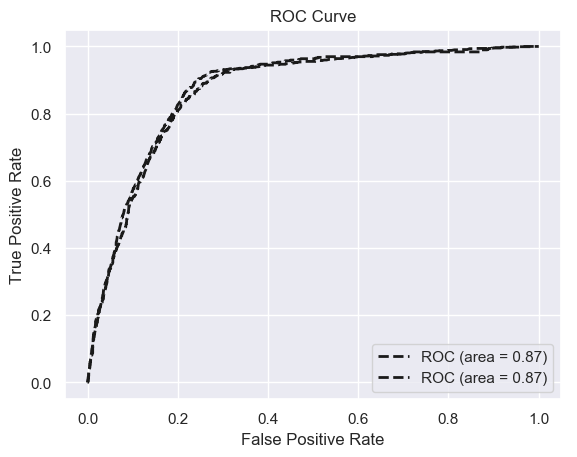

In [28]:
print('train ',model_metrics(lr,data_tr_woe.drop(['isDefault'],axis=1), data_tr_woe['isDefault']))
print('test ',model_metrics(lr,data_test_woe,test_y))

In [29]:
## 输出分数分布表，结合误杀率、召回率确定分数阈值

train_prob = lr.predict_proba(data_tr_woe.drop(['isDefault'],axis=1))[:,1]
test_prob = lr.predict_proba(data_test_woe)[:,1]


# Group the predicted scores in bins with same number of samples in each (i.e. "quantile" binning)
toad.metrics.KS_bucket(train_prob, data_tr_woe['isDefault'], bucket=10, method = 'quantile')

,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,total_prop,cum_bad_rate,cum_bad_rate_rev,cum_bads_prop,cum_bads_prop_rev,cum_goods_prop,cum_goods_prop_rev,cum_total_prop,cum_total_prop_rev,ks,lift,cum_lift
0,0.013095,0.044172,7,693,700,0.010000,0.990000,0.010101,0.005882,0.119277,0.100000,0.010000,0.170000,0.005882,1.000000,0.119277,1.000000,0.100000,1.000000,0.113395,0.058824,1.000000
1,0.044253,0.064526,11,688,699,0.015737,0.984263,0.015988,0.009244,0.118417,0.099857,0.012866,0.187778,0.015126,0.994118,0.237694,0.880723,0.199857,0.900000,0.222568,0.092569,1.104575
2,0.064724,0.083642,11,682,693,0.015873,0.984127,0.016129,0.009244,0.117384,0.099000,0.013862,0.209248,0.024370,0.984874,0.355077,0.762306,0.298857,0.800143,0.330708,0.093371,1.230873
3,0.083645,0.102783,19,686,705,0.026950,0.973050,0.027697,0.015966,0.118072,0.100714,0.017161,0.236553,0.040336,0.975630,0.473150,0.644923,0.399571,0.701143,0.432814,0.158531,1.391486
4,0.102812,0.131511,18,685,703,0.025605,0.974395,0.026277,0.015126,0.117900,0.100429,0.018857,0.271711,0.055462,0.959664,0.591050,0.526850,0.500000,0.600429,0.535588,0.150615,1.598298
5,0.131526,0.201181,19,680,699,0.027182,0.972818,0.027941,0.015966,0.117040,0.099857,0.020243,0.321143,0.071429,0.944538,0.708090,0.408950,0.599857,0.500000,0.636661,0.159892,1.889076
6,0.201227,0.682491,135,553,688,0.196221,0.803779,0.244123,0.113445,0.095181,0.098286,0.045017,0.394502,0.184874,0.928571,0.803270,0.291910,0.698143,0.400143,0.618396,1.154241,2.320600
7,0.683954,0.766771,237,474,711,0.333333,0.666667,0.500000,0.199160,0.081583,0.101571,0.081636,0.459063,0.384034,0.815126,0.884854,0.196730,0.799714,0.301857,0.500820,1.960784,2.700370
8,0.767060,0.821907,324,375,699,0.463519,0.536481,0.864000,0.272269,0.064544,0.099857,0.124027,0.522825,0.656303,0.615966,0.949398,0.115146,0.899571,0.200286,0.293095,2.726584,3.075438
9,0.822274,0.926851,409,294,703,0.581792,0.418208,1.391156,0.343697,0.050602,0.100429,0.170000,0.581792,1.000000,0.343697,1.000000,0.050602,1.000000,0.100429,-0.000000,3.422308,3.422308
